In [1]:
import numpy as np
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### Loading data

In [4]:
sentences=[]
label=[]
for line in open('Sarcasm_Headlines_Dataset.json', 'r'):
    dict_line=eval(line)
    sentences.append(dict_line['headline'])
    label.append(dict_line['is_sarcastic'])
print(len(sentences))
print(len(label))

26709
26709


In [5]:
## Splitting Data In Test Train
X_train, X_test, y_train, y_test = train_test_split(sentences, label, test_size=0.10, random_state=42,stratify=label)
print("Length of Training Set: ",len(X_train))
print("Length of Testing Set",len(X_test))


Length of Training Set:  24038
Length of Testing Set 2671


In [6]:
def tokenizing_sentences(sentences:list, num_words=100,oov_token='<OOV>', max_length=20):

    '''
    The Function takes a list of sentences to convert sentences into machine interpretable format
    Max_length decides to take only first max_lenth words in the sentences.

    ## Only Train data to be sent here ##

    Return:
        padded_sequences: Senteces that could be interpreted by machine
        tonkenizer: A class that would be used to convert test data into machine interpretable format
        max_lenth: Maximum length of sentences to be used
        vocab_size: Vocabulary size of your training example, to be used in embedding layer of Neural Network
    '''

    tokenizer=Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    word_index=tokenizer.word_index
    vocab_size=len(word_index.keys())
    sequences=tokenizer.texts_to_sequences(sentences)
    padded_sequences=pad_sequences(sequences, maxlen=max_length)

    return padded_sequences,tokenizer,max_length,vocab_size

In [7]:
X_train, tokenizer, max_length, vocab_size=tokenizing_sentences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,maxlen=max_length)

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

## The dataset is close to balanced.

[[    0 13486]
 [    1 10552]]


In [9]:
### Converting train test in numpy array
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [10]:
def define_model(vocab_size, embedding_dim, max_length):
    '''
    Creates a tensorflow model with said parameters:
    vocab_size: Size of your train data vocabulary
    embeddings dimensions of your traing data (every training data is defined as embedding_dim sized vector) 
    max_length
    
    Returns: A tensorflow sequential model
    '''

    model=tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(48, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model

model=define_model(vocab_size,25,max_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 25)            704125    
                                                                 
 global_average_pooling1d (G  (None, 25)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 48)                1248      
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                        

In [11]:
num_epochs = 50
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=10)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Text(0, 0.5, 'Accuracy')

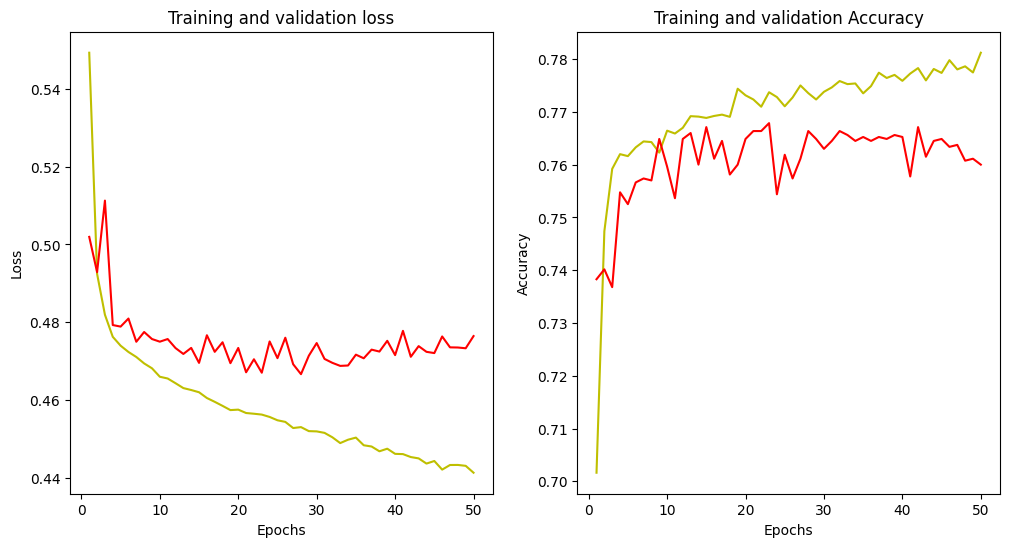

In [12]:
## Plotting Loss and Accuray Plots
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, (ax0,ax1)=plt.subplots(1,2, figsize=(12,6))
ax0.plot(epochs, loss, 'y', label='Training loss')
ax0.plot(epochs, val_loss, 'r', label='Validation loss')
ax0.set_title('Training and validation loss')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')

ax1.plot(epochs, acc, 'y', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'r', label='Validation Accuracy')
#ax1.set_ylim(bottom=0.7, top=0.9)
ax1.set_title('Training and validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')


#### Analysing The Model

In [13]:
y_pred=model.predict(X_test)
y_pred=y_pred.flatten()

84/84 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'ROC Curve')

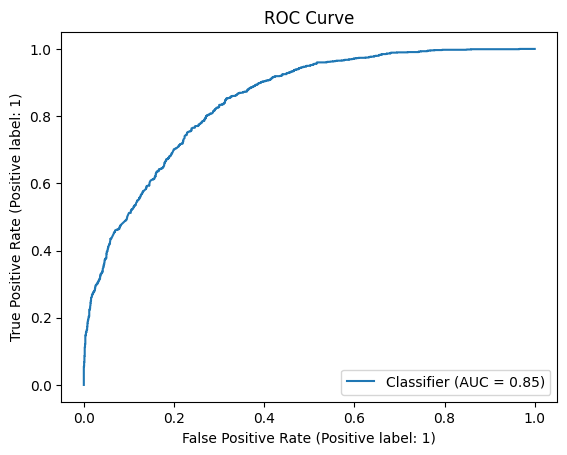

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds=ROC(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test,y_pred)
plt.title('ROC Curve')

In [15]:
## TO calculate optimum threshold value
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

Best Threshold: 0.46619999408721924 with G-Mean: 0.7637
FPR: 0.2728, TPR: 0.802


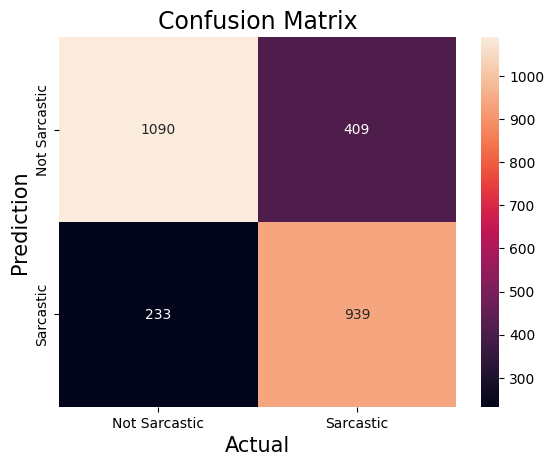

In [16]:
## Printing COnfusion Matrix
y_predictions=(y_pred>thresholdOpt).astype(int)
cm=confusion_matrix(y_test,y_predictions)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not Sarcastic','Sarcastic'],
            yticklabels=['Not Sarcastic','Sarcastic'])
plt.ylabel('Prediction',fontsize=15)
plt.xlabel('Actual',fontsize=15)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [17]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1499
           1       0.70      0.80      0.75      1172

    accuracy                           0.76      2671
   macro avg       0.76      0.76      0.76      2671
weighted avg       0.77      0.76      0.76      2671



#### TEST YOUR OWN SENTENCES

In [27]:
def test_you_sentence(sentences_func: list, model=model, threshold=thresholdOpt, tokenizer=tokenizer):
    ## For pleasing output ##
    mapping_dict={0:'Not Sarcastic',
                  1:'Sarcastic'}
    color_dict={0:'\033[92m ', 1:'\033[91m '}
    bold='\033[1m'
    #########################

    sequences_func=tokenizer.texts_to_sequences(sentences_func)
    padded_sequences_func=pad_sequences(sequences_func)

    pred_func=model.predict(np.array(padded_sequences_func))
    
    pred_func=pred_func.flatten()
    y_predictions_func=(pred_func>thresholdOpt).astype(int)
    print('\n')
    for number,sentence in enumerate(sentences_func):
        color=color_dict[y_predictions_func[number]]
        print(f'{bold+color}{sentence} : {mapping_dict[y_predictions_func[number]]}')

    return None

In [32]:
to_test=["Cows lose their jobs as milk prices drop","Miracle cure kills fifth patient",
         "Man Accused of Killing Lawyer Receives a New Attorney","Weather is punishing today","Cricket fever is on!!!",
         "Breathing oxygen linked to staying alive",
         "The threat of Global warming is real",'Things to do in this summer','India plans to boost their economy'] ## Add your sentences
test_you_sentence(to_test)

1/1 [==============================] - 0s 33ms/step


 Cows lose their jobs as milk prices drop : Sarcastic
 Miracle cure kills fifth patient : Sarcastic
 Man Accused of Killing Lawyer Receives a New Attorney : Sarcastic
 Weather is punishing today : Not Sarcastic
 Cricket fever is on!!! : Not Sarcastic
 Breathing oxygen linked to staying alive : Sarcastic
 The threat of Global warming is real : Not Sarcastic
 Things to do in this summer : Not Sarcastic
 India to boost their economy : Not Sarcastic
